# Análise de Dados - RIOT API


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from dotenv import load_dotenv
import os

load_dotenv()

API_KEY = os.getenv("RIOT_API_KEY")
sns.set(style='whitegrid')

## 1. Importando os Dados

Vamos importar os dados da nossa API

In [4]:
headers = {"X-Riot-Token": API_KEY}
gameName = "Cayo"
tagLine = "054" 
url_account = f"https://americas.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{gameName}/{tagLine}"
resp = requests.get(url_account, headers=headers)

if resp.status_code == 200:
    account_data = resp.json()
    puuid = account_data["puuid"]
    print("PUUID:", puuid)
else:
    raise Exception("Erro ao buscar Riot ID:", resp.status_code, resp.text)  


PUUID: S3w4o2mUsMoXm0ri1qlMiL5iuiKe-blnOPCeFDBqXYI2Dx49M2tNU2udH3sD0VauW5NoYwybC7qt-Q


## 2. Mostrando os Dados da Ultimas 5 partidas
Primeiro iremos puxar as ultimas 

In [ ]:
url_matches = f"https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?start=0&count=20"
resp_matches = requests.get(url_matches, headers=headers)

if resp_matches.status_code != 200:
    print("Erro ao buscar partidas:", resp_matches.status_code, resp_matches.text)
    exit()

match_ids = resp_matches.json()

Erro ao buscar partidas: 400 {"status":{"message":"Bad Request - invalid parameter value 500, must be between 0 and 100","status_code":400}}


: 

Logo após vamos destrinchar essas partidas, no caso vamos detalhar cada partida em uma "tabela" para isso vamos separa-la

In [6]:
matches_data = []
for match_id in match_ids:
    url_detail = f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}"
    resp_detail = requests.get(url_detail, headers=headers)
    if resp_detail.status_code == 200:
        match_detail = resp_detail.json()
        
        for participant in match_detail['info']['participants']:
            if participant['puuid'] == puuid:
                matches_data.append({
                    "match_id": match_id,
                    "Campeão": participant['championName'],
                    "Abates": participant['kills'],
                    "Morte": participant['deaths'],
                    "Assistencias": participant['assists'],
                    "Vitória": participant['win'],
                    "Total de Dano": participant['totalDamageDealtToChampions'],
                    "Ouro Adquirido": participant['goldEarned'],
                    "cs": participant['totalMinionsKilled'] + participant['neutralMinionsKilled']
                })
                break
    else:
        print(f"Erro ao buscar detalhes da partida {match_id}: {resp_detail.status_code}")

Agora iremos transformar em um dataframe

In [7]:
df_matches = pd.DataFrame(matches_data)
print(df_matches)

          match_id     Campeão  Abates  Morte  Assistencias  Vitória  \
0   BR1_3146748728     Chogath       4      7             2    False   
1   BR1_3145525996       Teemo      19     14            32    False   
2   BR1_3144888008      RekSai       6      8            10    False   
3   BR1_3144875358       Corki       9      9             4     True   
4   BR1_3144859979  Cassiopeia      11      3            10     True   
5   BR1_3144847980     Camille      10      4             4     True   
6   BR1_3144584297       Senna       5      3            16    False   
7   BR1_3144574789        Rell       0      1             2    False   
8   BR1_3144559911        Shen       6      3            11     True   
9   BR1_3144392243    Nautilus       2      8            17    False   
10  BR1_3144378827     Skarner       4      1            10     True   
11  BR1_3143575795      Rammus       4      1            19     True   
12  BR1_3143560814       Briar       9      9             4    F

## 4. Grafico de Demonstração de Ouro
Média de Ouro das ultimas 20 partidas

C:\Users\cayov\AppData\Local\Temp\ipykernel_17664\4086176049.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


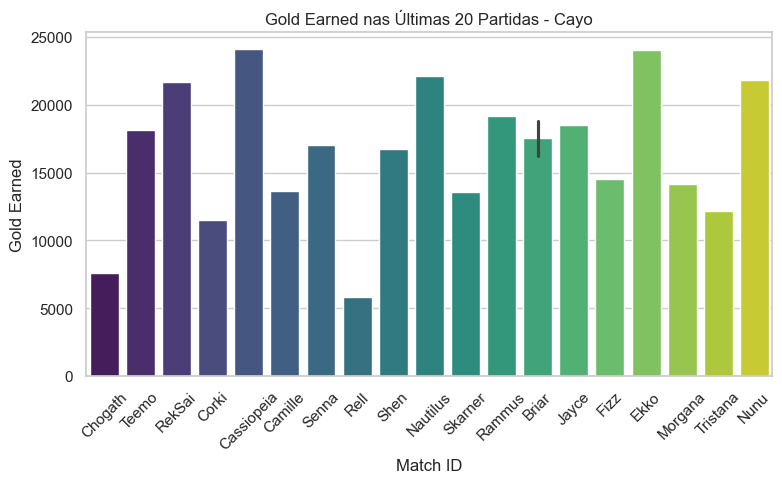

In [8]:
plt.figure(figsize=(8,5))
sns.barplot(
    x="Campeão", 
    y="Ouro Adquirido", 
    data=df_matches,
    palette="viridis"
)
plt.title(f"Gold Earned nas Últimas 20 Partidas - {gameName}")
plt.xlabel("Match ID")
plt.ylabel("Gold Earned")
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

## 5. Gráfico de Vitória e Derrotas
Aqui analisamos uma média da duração de partidas, asim analizando a frequencia e a duração

C:\Users\cayov\AppData\Local\Temp\ipykernel_17664\1776892109.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


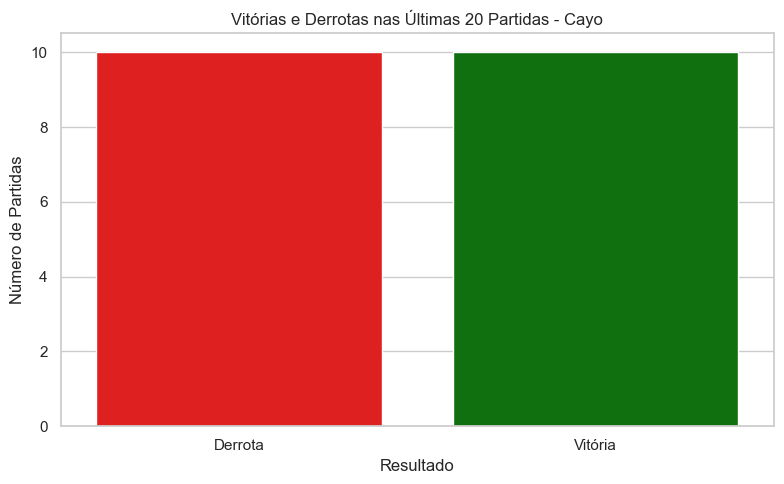

In [9]:
df_matches['resultado'] = df_matches['Vitória'].apply(lambda x: 'Vitória' if x else 'Derrota')

plt.figure(figsize=(8,5))
sns.countplot(
    x='resultado',
    data=df_matches,
    palette={'Vitória':'green', 'Derrota':'red'}
)
plt.title(f"Vitórias e Derrotas nas Últimas 20 Partidas - {gameName}")
plt.xlabel("Resultado")
plt.ylabel("Número de Partidas")
plt.tight_layout()
plt.show()

## 6. Gráfico de Abates, Assistencias e Morte


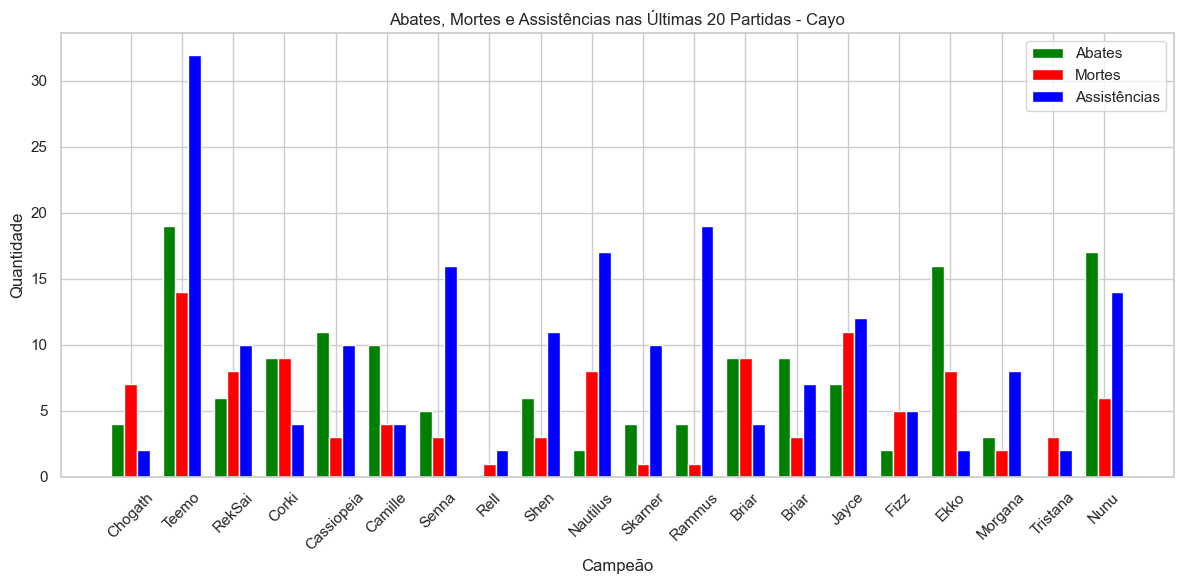

In [10]:
x = np.arange(len(df_matches))
width = 0.25
plt.figure(figsize=(12,6))

plt.bar(x - width, df_matches['Abates'], width=width, color='green', label='Abates')

plt.bar(x, df_matches['Morte'], width=width, color='red', label='Mortes')

plt.bar(x + width, df_matches['Assistencias'], width=width, color='blue', label='Assistências')

plt.xticks(x, df_matches['Campeão'], rotation=45)

plt.title(f"Abates, Mortes e Assistências nas Últimas 20 Partidas - {gameName}")
plt.xlabel("Campeão")
plt.ylabel("Quantidade")
plt.legend()
plt.tight_layout()
plt.show()

## 7. Gráfico de KDA com a média
No jogo, temos os objetivo, que dão fortalecimento ao time que realizar eles, nesse gráfico vemos a média de objetivo para o time vencedor

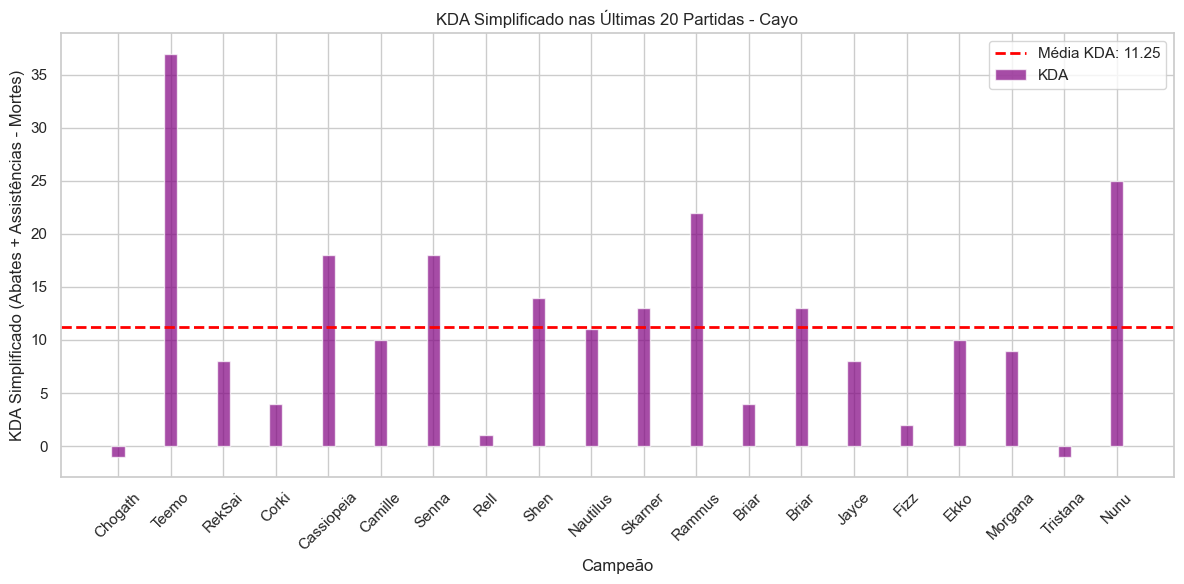

In [11]:
df_matches['KDA'] = df_matches['Abates'] + df_matches['Assistencias'] - df_matches['Morte']

plt.figure(figsize=(12,6))

plt.bar(x, df_matches['KDA'], width=width, color='purple', alpha=0.7, label='KDA')

plt.axhline(df_matches['KDA'].mean(), color='red', linestyle='--', linewidth=2, label=f'Média KDA: {df_matches["KDA"].mean():.2f}')

plt.xticks(x, df_matches['Campeão'], rotation=45)

plt.title(f"KDA Simplificado nas Últimas 20 Partidas - {gameName}")
plt.xlabel("Campeão")
plt.ylabel("KDA Simplificado (Abates + Assistências - Mortes)")
plt.legend()
plt.tight_layout()
plt.show()

## 8. Mapa de Correlação

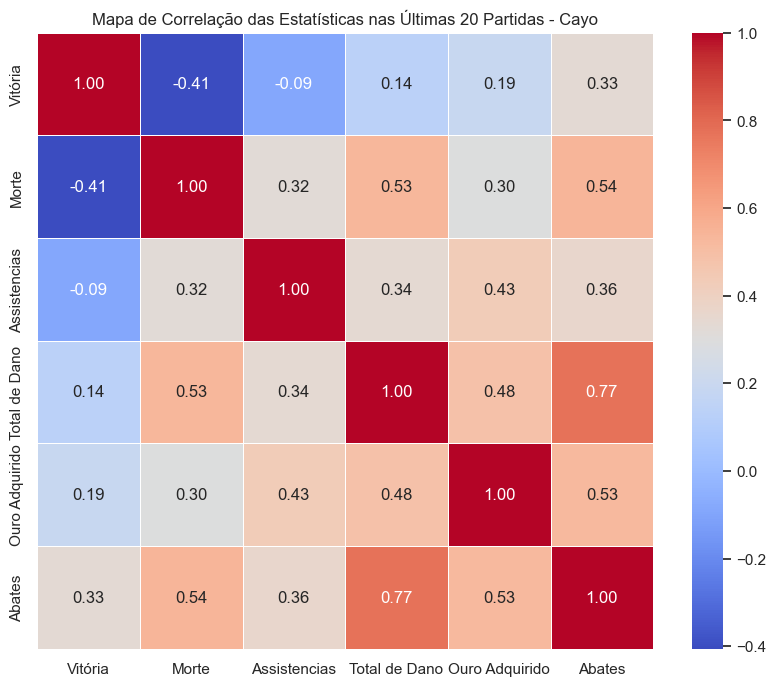

In [12]:
df_matches = pd.DataFrame(matches_data)
df_corr = df_matches[['Vitória', 'Morte', 'Assistencias', 'Total de Dano', 'Ouro Adquirido', 'Abates']]
corr_matrix = df_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,       
    cmap='coolwarm',  
    fmt=".2f",        
    linewidths=0.5,
    square=True
)
plt.title(f"Mapa de Correlação das Estatísticas nas Últimas 20 Partidas - {gameName}")
plt.show()

# 9.Salvando em CSV

In [13]:
df_matches.to_csv("partidas.csv", index=False)

print("Arquivo 'partidas.csv' Pronto!")

Arquivo 'partidas.csv' Pronto!
